In [1]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.stats import pointbiserialr
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
)
from side_info_decoding.bmm_hmm import (
    BetaProcess, HMM, Oracle_BMM_HMM, posterior_inference
)
from side_info_decoding.viz import plot_bmm_hmm_results
seed = 666

In [2]:
brain_region = "dg"

dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    "16799c7a-e395-435d-a4c4-a678007e1550",
    "1e176f17-d00f-49bb-87ff-26d237b525f1",
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "31f3e083-a324-4b88-b0a4-7788ec37b191",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf",
    "ad714133-1e03-4d3a-8427-33fc483daf1a"
]

ys, ds = [], []
for _, pid in enumerate(pids):

    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"choice"/"all"/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        d.append(
            np.load(
                dir_path/pid/"choice"/brain_region/"y_prob"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"choice"/"all"/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx),1]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

/tmp/ipykernel_60143/3632050337.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array(ys)
/tmp/ipykernel_60143/3632050337.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds = np.array(ds)


In [3]:
pid = pids[-1]
print(pid)
print(brain_region)
d = ds[-1].squeeze()
y = ys[-1].squeeze()

save_path, save_metrics = {}, {}
out_path = Path("/home/yizi/side_info_decoding/saved_results")
for res in ["oracle_bmm_hmm_metrics", "oracle_bmm_hmm_figures"]:
    save_path.update({res: out_path/res/pid})
    os.makedirs(save_path[res], exist_ok=True)

ad714133-1e03-4d3a-8427-33fc483daf1a
dg


In [4]:
# learn hmm params from observed choices

init_pi = {0: np.log(.4), 1:np.log(.5), 2: np.log(.1)}
init_a = {
        0: {0: np.log(.6), 1: np.log(.3), 2: np.log(.1)},
        1: {0: np.log(.3), 1: np.log(.6), 2: np.log(.1)},
        2: {0: np.log(.1), 1: np.log(.3), 2: np.log(.6)} }
init_b = {
        0: {0: np.log(.6), 1: np.log(.4)},
        1: {0: np.log(.4), 1: np.log(.6)},
        2: {0: np.log(.6), 1: np.log(.4)}
         }
p = [init_pi, init_a, init_b]

hmm = HMM(p)
hmm.update(y, 1e-5)

oracle_states = np.array([np.array(list(state.values())) for state in hmm.forward(y)])
oracle_states = np.exp(oracle_states)
oracle_states = oracle_states / oracle_states.sum(1)[:,None]

a_hat = hmm.forward_backward(y)[1]
b_hat = hmm.forward_backward(y)[2]
A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)
B = np.exp(
    [[b_hat[0][0], b_hat[0][1]], 
     [b_hat[1][0], b_hat[1][1]],
     [b_hat[2][0], b_hat[2][1]]]
)

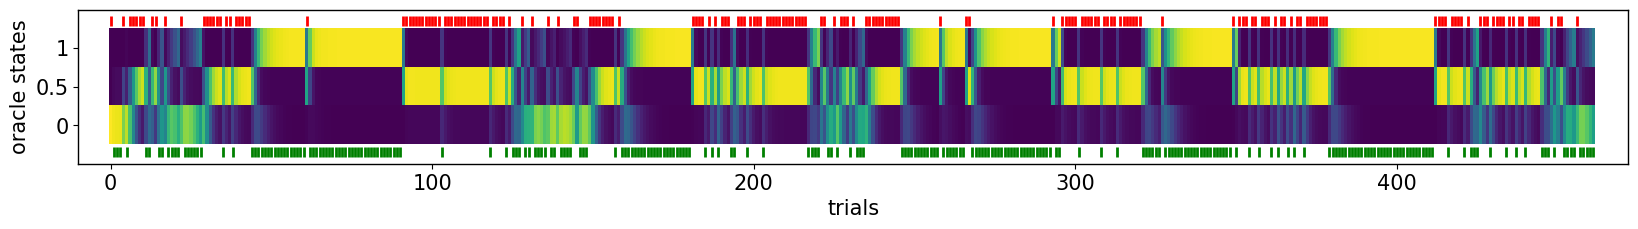

oracle transition probs.:
[[9.29088917e-01 7.09086336e-02 2.44964459e-06]
 [2.45712632e-02 9.38009142e-01 3.74195953e-02]
 [8.70723989e-13 3.92805623e-02 9.60719438e-01]]

oracle emission probs.:
[[0.6576357  0.3423643 ]
 [0.1921844  0.8078156 ]
 [0.97160996 0.02839004]]


In [5]:
plt.figure(figsize=(20,2))
plt.imshow(oracle_states.T, aspect="auto")
plt.eventplot(np.where(y == 1.), colors="r", lineoffsets=2.7, linelengths=.25, linewidth=2., label="R")
plt.eventplot(np.where(y == 0.), colors="g", lineoffsets=-.7, linelengths=.25, linewidth=2., label="L")
plt.xlabel("trials")
plt.ylabel("oracle states")
plt.yticks([0,1,2], [0,0.5,1])
plt.ylim(-1, 3.)
plt.xlim(-10, len(oracle_states)+10.)
plt.show()

print("oracle transition probs.:")
print(A)
print("")
print("oracle emission probs.:")
print(B)

In [6]:
# learn bmm params from observed choices

with pm.Model() as beta_model:
    alpha = pm.Exponential("a", 1, shape = 2)
    beta = pm.Exponential("b", 1, shape = 2)
    dk = BetaProcess('d', y, alpha, beta, observed=d)
    step = pm.NUTS()     
    trace = pm.sample(draws=1000, step=step, chains=2, progressbar=True)  
    beta_ppc = pm.sample_posterior_predictive(
        trace, var_names=["a", "b", "d"], random_seed=seed
    )
a0, a1 = beta_ppc["a"].mean(0)
b0, b1 = beta_ppc["b"].mean(0)
print(a0, b0, a1, b1)

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


0.29174491687589116 0.6708066287193611 0.4998415815089701 0.36989112118572776


In [8]:
# initialize bmm-hmm

states = [0, 1, 2]
init_pi = {0:hmm.pi[0], 1:hmm.pi[1], 2:hmm.pi[2]}
init_a = {
    0: {0: np.log(A[0][0]), 1: np.log(A[0][1]), 2: np.log(A[0][2])},
    1: {0: np.log(A[1][0]), 1: np.log(A[1][1]), 2: np.log(A[1][2])},
    2: {0: np.log(A[2][0]), 1: np.log(A[2][1]), 2: np.log(A[2][2])} 
}
init_phi = {
    0: {0: np.log(B[0][0]), 1: np.log(B[0][1])},
    1: {0: np.log(B[1][0]), 1: np.log(B[1][1])},
    2: {0: np.log(B[2][0]), 1: np.log(B[2][1])}
}
init_beta_a = [a1, a0]
init_beta_b = [b1, b0]

# fit bmm-hmm

bmm_hmm = Oracle_BMM_HMM(d, init_pi, init_a, init_phi, init_beta_a, init_beta_b, tol=1e-1)
bmm_hmm.update(d)

In [9]:
a_hat = bmm_hmm.a
phi_hat = bmm_hmm.phi
beta_a_hat = bmm_hmm.beta_a
beta_b_hat = bmm_hmm.beta_b

In [10]:
# inference

A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)

B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(d)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
post_preds, post_probs = posterior_inference(bmm_hmm, d)

save_metrics.update({
    "acc": {
        "baseline": accuracy_score(y, [1 if d_k > .5 else 0 for d_k in d]),
        "bmmhmm": accuracy_score(y, post_preds)
    }
})
save_metrics.update({
    "auc": {
        "baseline": roc_auc_score(y, d),
        "bmmhmm": roc_auc_score(y, post_probs)
    }
})
save_metrics.update({
    "corr": {
      "baseline": pointbiserialr(y, d)[0],
      "bmmhmm": pointbiserialr(y, post_probs)[0]
    },
})
np.save(save_path["oracle_bmm_hmm_metrics"] / f"{brain_region}.npy", save_metrics)

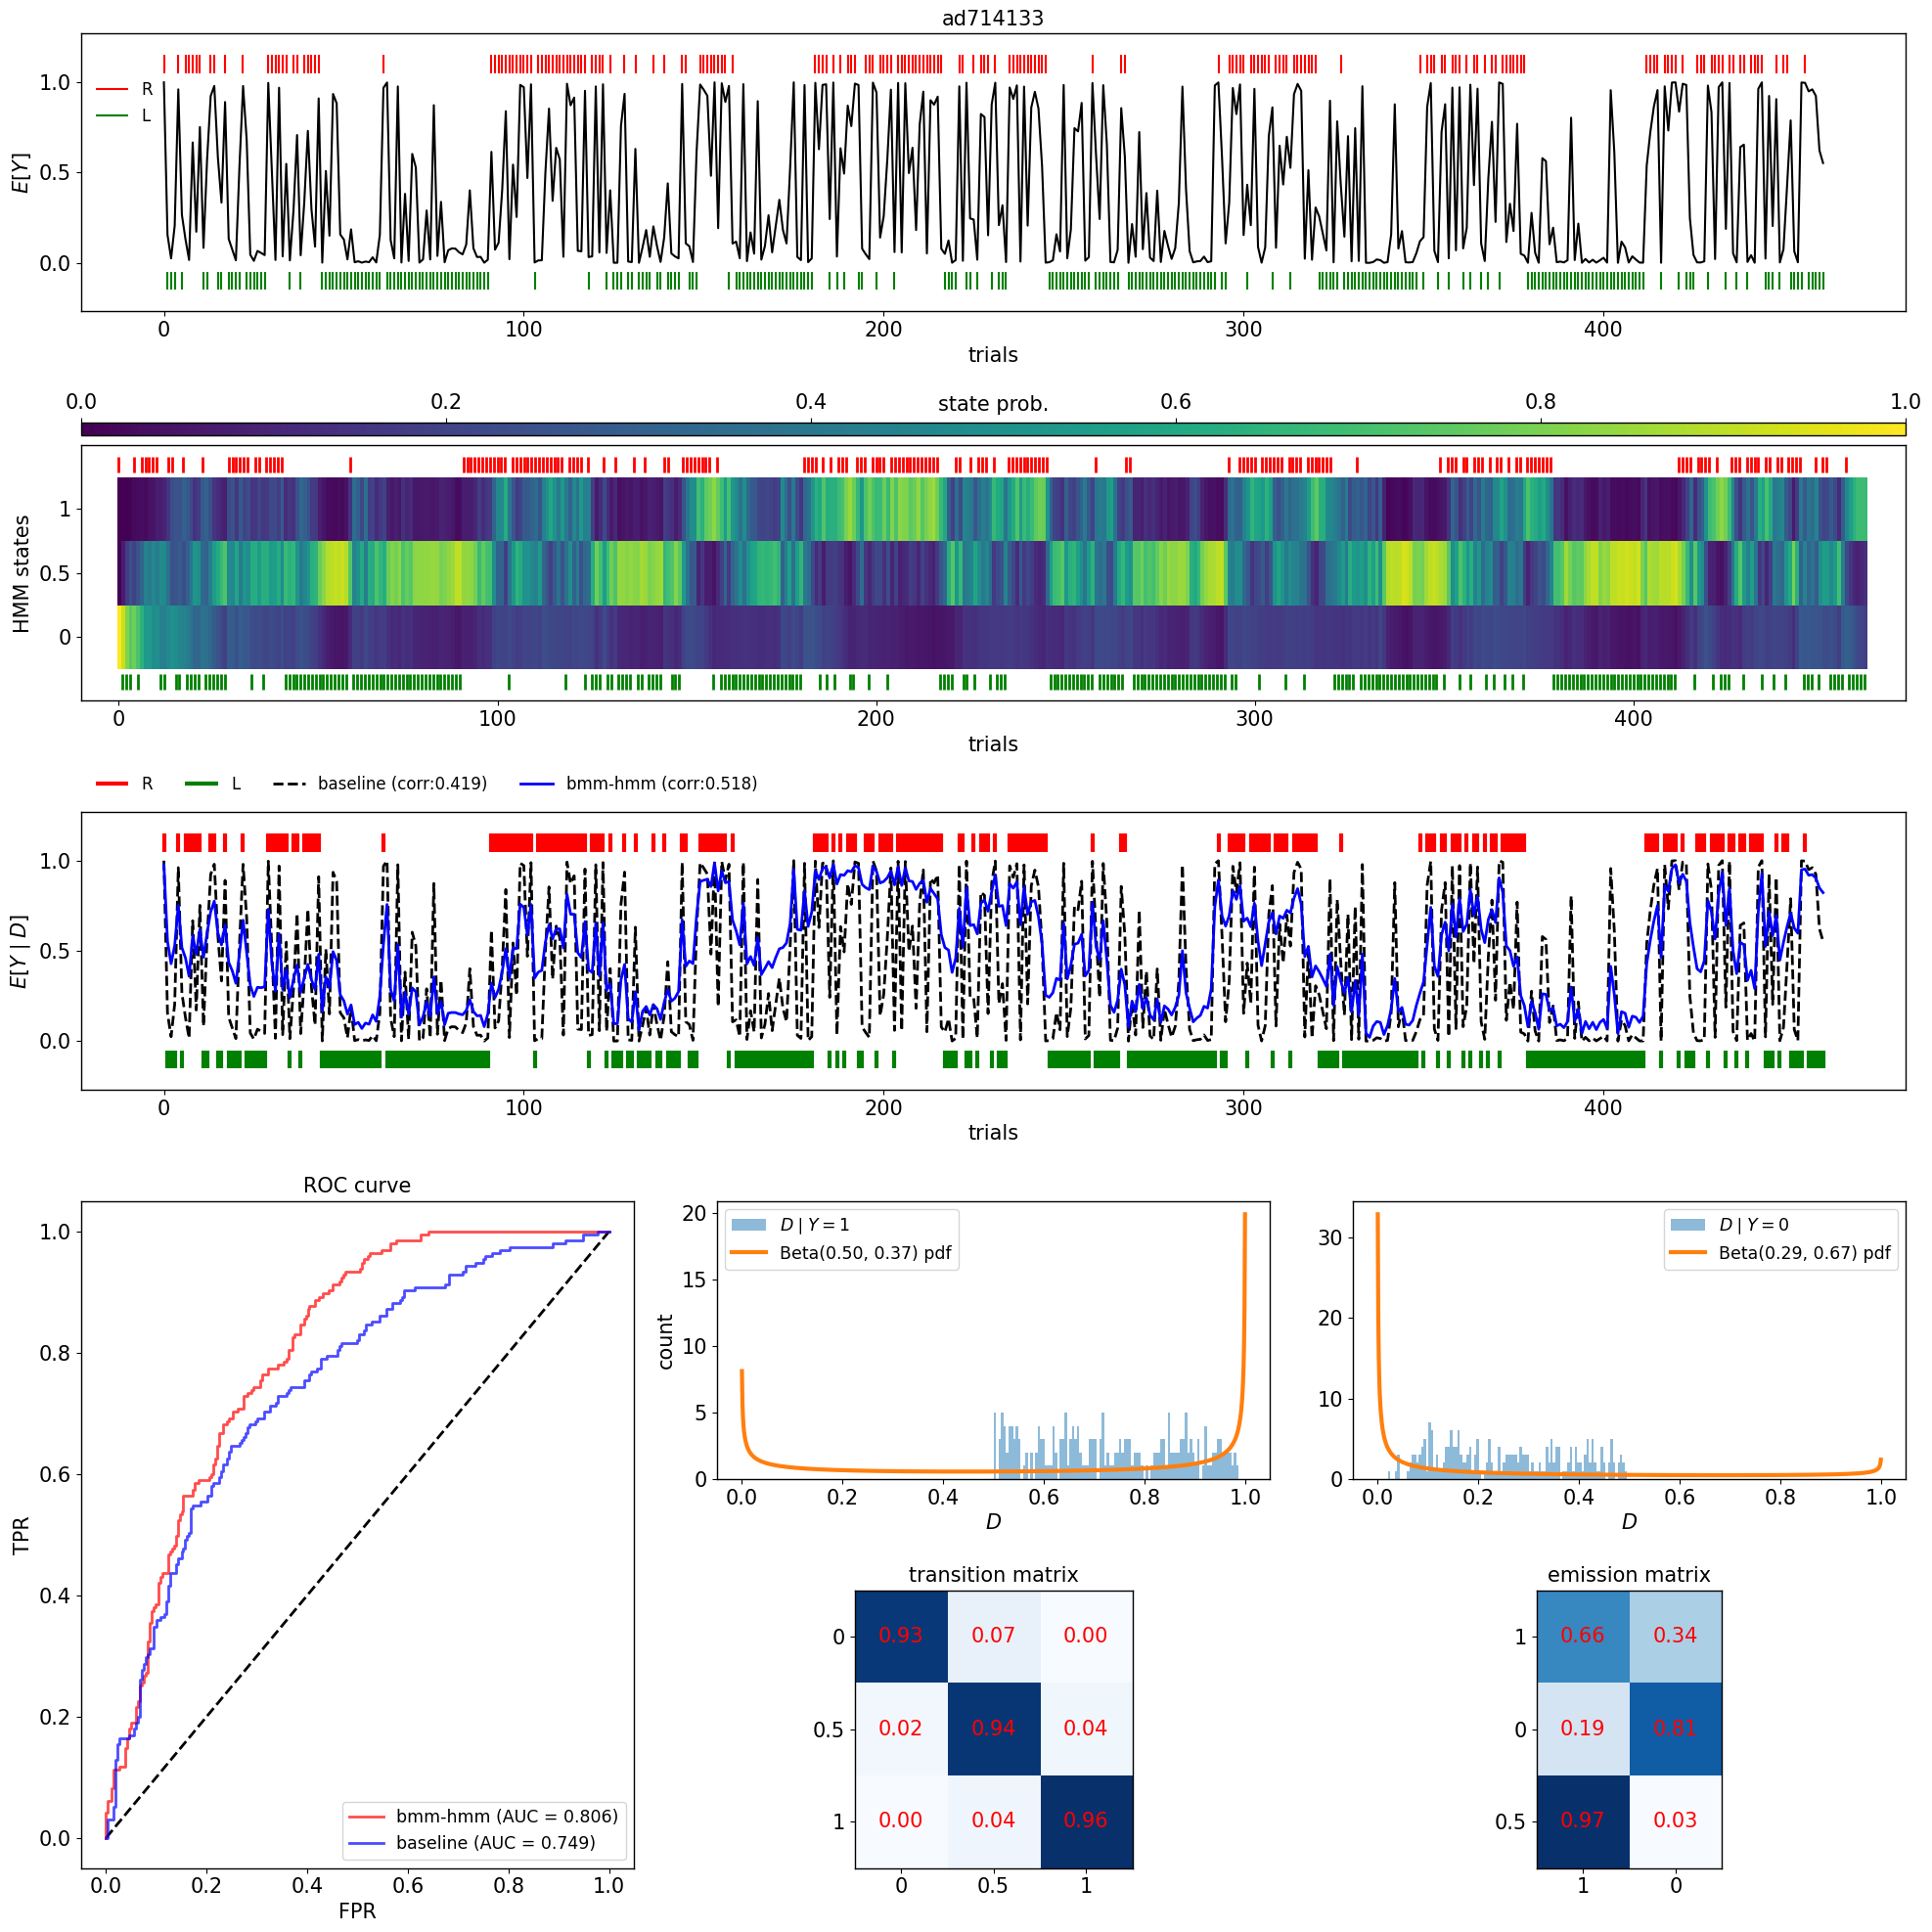

In [11]:
plot_bmm_hmm_results(
    estimates=d,
    post_preds=post_preds,
    post_probs=post_probs,
    states=states,
    choices=y,
    params=(A, B, beta_a_hat, beta_b_hat),
    save_metrics=save_metrics,
    pid=pid,
    brain_region=brain_region
)